# **WorkShop de Inteligencia Artificial Congreso Chileno de Radiología 2022**


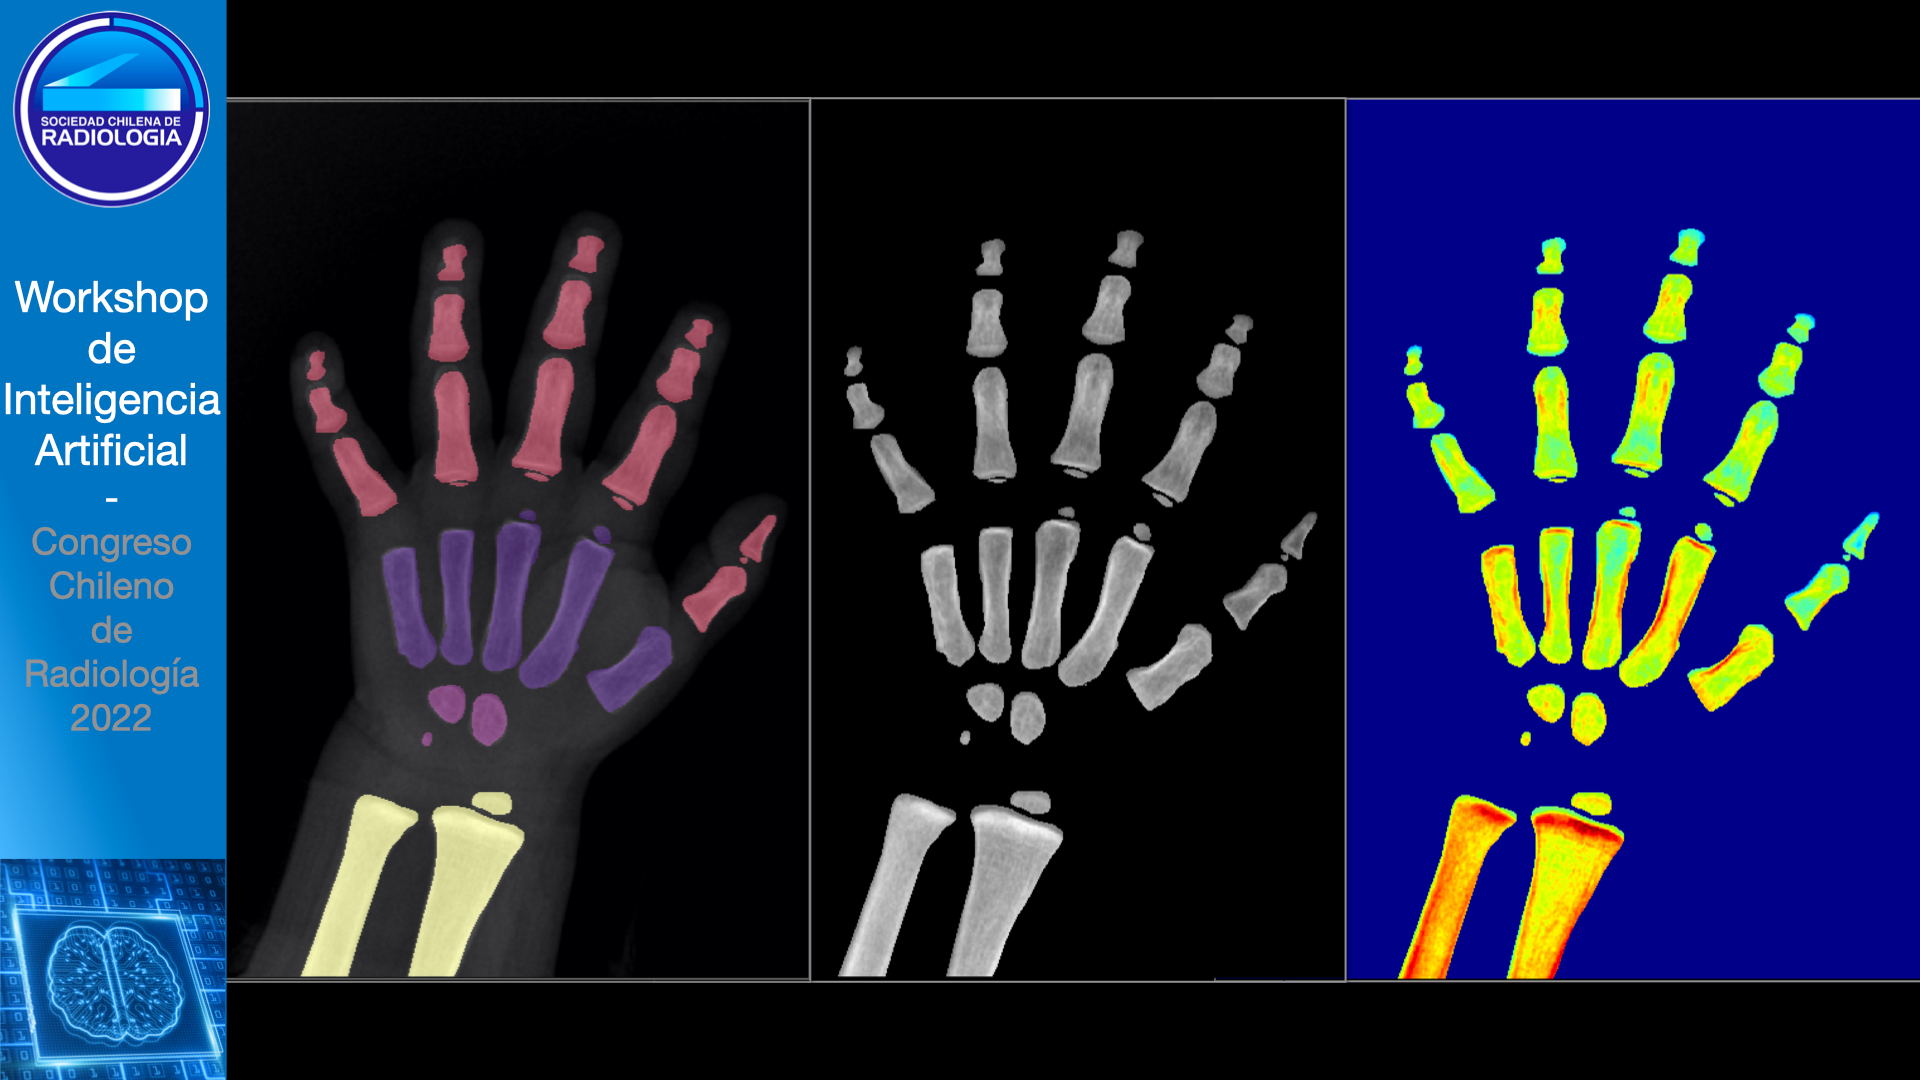

Director de Módulo:

*   Dr. Héctor Henríquez Leighton.

Colaboradores:

*   Dr. Benjamín Pizarro Galleguillos.
*   Dr. Felipe Castillo Aravena.


# Introducción
Las siguientes líneas de código permiten importar las librerías, que en otras palabras corresponde a un conjunto de código con funciones determinadas que ya fueron realizados por otra persona y podemos volver a utilizar. 
También hay librerías que nos permiten entrenar modelos de machine learning, dos de los frameworks más utilizados son TensorFlow, Keras y PyTorch. Cada uno tiene sus ventajas y desventajas. Para este notebook en particular utilizaremos TensorFlow y Keras. Keras es de alto nivel, lo que quiere decir que es más amigable para interactuar con humanos.

In [ ]:
## Librerias generales de manejo de datos numéricos
import numpy as np # Esta libreria nos permite manejar "arrays"
import pandas as pd # Esta libreria nos permite manejar "dataframes"
import json # json es un formato de archivo
from sklearn.model_selection import train_test_split # sklearn es una librería para utilizar modelos de machine learning y funcionalidades asociadas
import statsmodels.api as sm # Libreria para utilizar herramientas estadísticas

## Librerías de visualización
import matplotlib.pyplot as plt 
from plotnine import*
import cv2
## Librerias de keras para construcción y entrenamiento de Modelo Deep Learning

### Inception es un tipo de Red Neuronal
### Para saber más puedes ver este link https://paperswithcode.com/method/inception-v3
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input,concatenate

### Métodos de optimización de funciones
### Para saber más puedes ver este link https://velascoluis.medium.com/optimizadores-en-redes-neuronales-profundas-un-enfoque-pr%C3%A1ctico-819b39a3eb5
from tensorflow.keras.optimizers import SGD, RMSprop, Adam 

### MeanAbsoluteError es un tipo de funcion de pérdida 
### Para saber más puedes visitar este link https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1, l2

## Utilidades para ver advertencias y hacer solicitudes
import requests
import warnings
warnings.filterwarnings('ignore')

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.githubusercontent.com/HectorHenriquez/Bone-Age-WorkShop-Congreso/main/kaggle.json")
token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/traindata-boneage-challenge
!unzip /content/traindata-boneage-challenge.zip

# Análisis exploratorios
En las siguientes líneas de código, iremos realizando etapas sucesivas para entrenar nuestra red neuronal para predecir la edad en base a las radiografías y el género. 

In [ ]:
## Carga de Tensor con imágenes
data = np.load('tensorBoneAgeTrain160x200.npy', allow_pickle=True)

print("Cantidad de imágenes:{},\nAncho de imágenes:{} pixeles, Alto de imágenes:{} pixeles".
      format(data.shape[0],data.shape[2],data.shape[1]))


## Visualización de las radiografías

In [ ]:
## Muestra aleatoria de las radiografías cargadas
index = np.random.randint(0,data.shape[0])

### También puedes ver una imagen determinada, para esto elimina el "#" de la siguiente
### linea y escribe el número de la imagen que deseas visualizar 
# index = 1204

print('Imagen:', index)
plt.figure(figsize=(7,7))
plt.imshow(data[index,:,:], cmap='gray')
plt.show()

## Carga de datos clínicos y análisis de estos

In [ ]:
## Carga de Data Clínica
### CSV es un tipo de archivo, muy similar a un Excel, donde cada columna esta delimitada por una coma. 
url = 'https://raw.githubusercontent.com/HectorHenriquez/Bone-Age-WorkShop-Congreso/main/TrainDataBoneAgeChallenge.csv'

### Cargamos la información como un "data frame" usando la librería pandas
dataClinica = pd.read_csv(url) 

## Previsualización de tabla de datos:
### head es un método del objeto "dataframe" que nos permite visualizar los primeros valores de un dataframe 
### Si deseas ver más valores solo debes cambiar el número dentro del paréntesis
dataClinica.head(6) 

Antes de realizar un análisis e implementar las redes neuronales u otras técnicas es importante conocer los datos por lo cuál siempre es recomendable
realizar un análisis exploratorio de los datos

In [ ]:
## Análisis exploratorio:

## Edades
print("Promedio de edad: {} años\n".format(round(data.mean()/12,2)))
(ggplot(dataClinica) + aes(x='boneage/12') + 
 geom_histogram(fill='dodgerblue', color='black') +
 theme_bw() +
 labs(title='Distribución de edades de los pacientes', x='Edad (años)', y='Recuento')+
 scale_x_continuous(breaks=list(range(0,21,1)))
)

In [ ]:
## Género
(
    ggplot(dataClinica)+
 aes(x='male', fill='male') +
 geom_bar(show_legend=False) + 
 theme_bw() +
 labs(title='Distribución de Género', y='Recuento', x = 'Género' ) +
    scale_y_continuous(breaks=list(range(0,7500,500))) +
 scale_x_discrete(labels=['Femenino', 'Masculino']) +
  scale_fill_manual(values=['sandybrown', 'dodgerblue'])

)

# Preparando el dataset para el entrenamiento y el testeo de la red neuronal
Es muy importante separar el conjunto de los datos, en datos de entrenamiento y datos de testeo. El objetivo de esto es evitar que los modelos se sobreajusten. Conceptualmente lo que nos interesa es lograr que nuestro modelo tenga un buen desempeño en nuestro conjunto de datos, pero también en datos externos. Esto se conoce como la capacidad de generalización. 
Por poner una analogía,  si nuestro modelo tuviera un buen desempeño solo en el conjunto de entrenamiento, pero no en el testeo, es decir sobreajustado, sería como un estudiante que se aprende de memoria las respuestas de preguntas con las que estudia, pero que cuando llega la prueba no es capaz de responderla porque las preguntas cambiaron y realmente no aprendió la materia. 


In [ ]:
## Separación aleatoria de conjuntos de entrenamiento y prueba

index = np.array(list(range(0,data.shape[0])))

## Uso de semilla para que todos podamos tener la misma partición de datos
seed = 40

### Train_test_split es una función muy util de la librería scikitlearn que nos permite separar los datos 
### de forma aleatoria en estos conjuntos, el test_size es el porcentaje de las imágenes que se separarán
### Para posteriormente testear el modelo, habitualmente se usan valores entre 0.1 a 0.3.

X_train, X_test, y_train, y_test = train_test_split(index, index, test_size=0.1, random_state=seed) 

## Por razones de memoria, sólo usaremos los indices de la separación y los 
## aplicaremos directamente sobre el único set de datos de imágenes.

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Preprocesamiento

La mayoría de las veces no podremos utilizar las imágenes u otro tipo de información de forma directa como input para los modelos. Tenemos que modificar estos de forma de adaptarlos a la geometría requerida por las arquitecturas y ajustar los valores de los datos, de manera sw obtener el mejor rendimiento de los modelos. En el caso de las imágenes siempre debemos **normalizar (dejar el valor de los pixeles entre 0 y 1)** o **estandarizar (dejar los valores de intensidad de los pixeles con media 0 y desviación estándar de 1)** la intensidad de los pixeles. 
Si quieres aprender otras maneras en las que puedes realizar esto puedes revisar el siguiente video https://es.coursera.org/lecture/analisis-de-datos-con-python/normalizacion-de-datos-en-python-pqNBS

* Otros pasos habituales en el preprocesamiento de las imágenes:
* * Resampling (cambiar el tamaño del voxel de las imágenes volumétricas).
* * Transformación de histograma: Ajustar los valores de intensidad de la imagen, ya sea para resaltar alguna características o bien dejar las imágenes más homogéneas.
* * Discretización: Agrupar los valores de la intensidad, de manera de reducir la variabilidad de las imágenes.

In [ ]:
## Preprocesamiento:
## 1. Normalización del valor de los pixeles (0 - 1)
data = data/255

## 2. Reshape: ajuste de las dimensiones esperadas del tensor. Formato: (numero de imagenes, altura, ancho, canales)
data = data.reshape(data.shape[0], data.shape[1], data.shape[2],1)

## Dimensiones de nuestro set de datos luego del preprocesamiento.
print(data.shape)

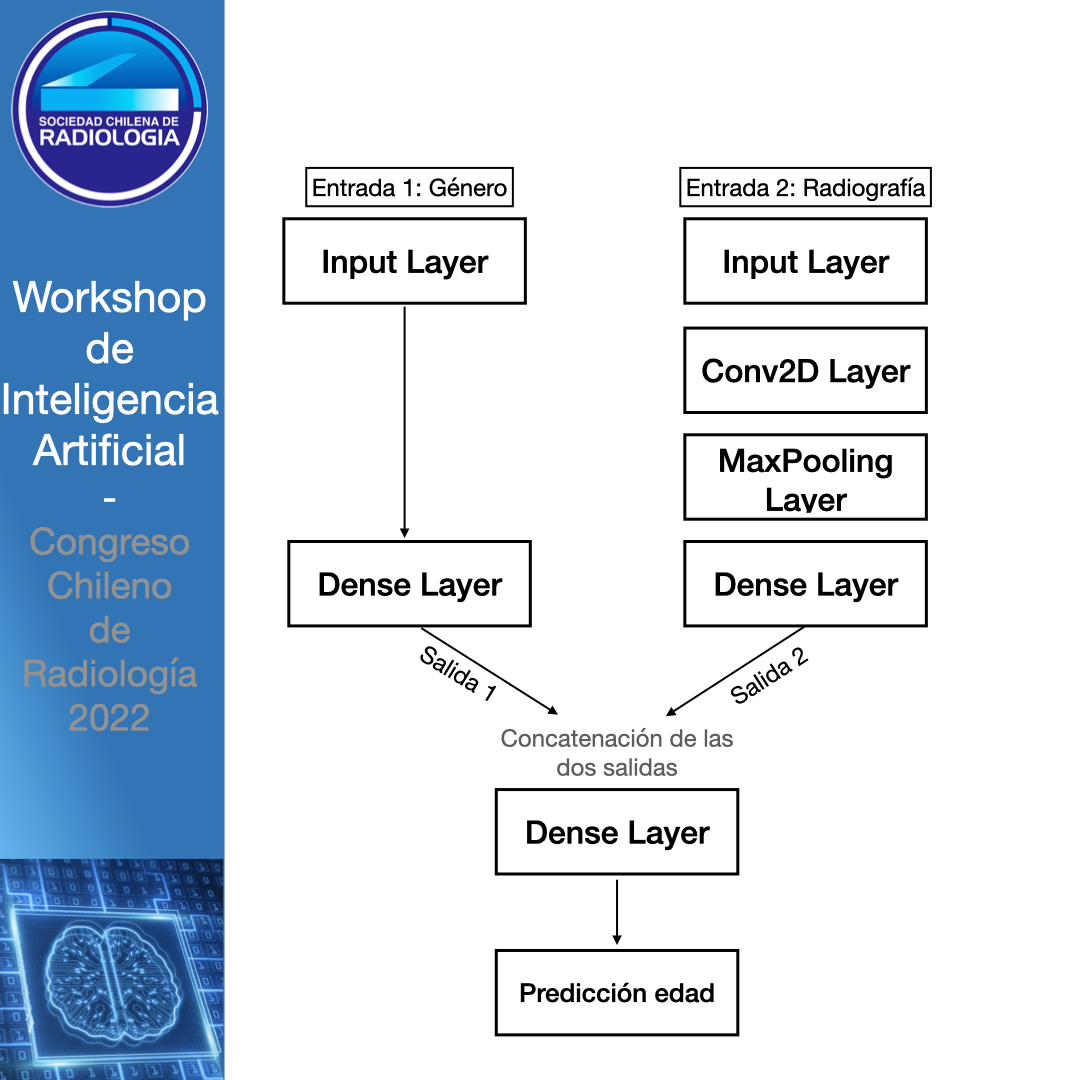

# Hiperparámetros
Para entender este concepto es importante conocer qué es un "parámetro" de un modelo. Los parámetros corresponden a valores que definen al modelo, los cuales son aprendidos en el proceso de entrenamiento del mismo. Sin embargo, los hiperparámetros corresponden en palabras simples a la "configuración del modelo". Estos se deben definir a prior o bien buscarlos con técnicas iterativas. Distintos hiperparámetros resultarán en diferentes resultados en el rendimiento del modelo. Por lo anterior existen estrategias para probar distintos hiperparámetros, las cuales no tocaremos en este tutorial. Sin embargo, puedes probar modificando los hiperparámetros definidos más abajo y ver como cambian los resultados de tu red neuronal.

In [ ]:
## Definicion hiperparametros

## El Learning rate corresponde a con cuanta "velocidad" iremos modificando los pesos de la red a medida que se van ajustando
## durante el proceso de entrenamiento
LR = 0.001

## Las épocas corresponden a cuantas veces le entregaremos la totalidad los datos a la red neuronal para ser entrenada

EPOCHS = 10  ## No superar los 50 debido al tiempo de entrenamiento...sino no alcanzarás a participar en el concurso!!

## El batch size corresponde a cuantos "paquetes de imágenes" le iremos entregando a la red neuronal
## durante cada una de las epocas, hasta haber entregado la totalidad de las imágenes

BATCH_SIZE = 64  ## no superar los 128 debido a limites de memoria de Google Colab!!!

## Dividimos un conjunto de validación de las imágenes para optimizar los hiperparámetros
VAL_SPLIT = 0.1

## El número de neuronas es un hiperparámetros y podemos probar distintas configuraciones para evaluar el rendimiento del modelo
NEURONAS_CLASIFICADOR = 16

## El drop out es une técnica de regularización para evitar el sobreajuste donde vamos apagando neuronas del modelo.
## Una analogía es como un deportista al cual para mejorar su rendimiento en una carrea de atletismo se pone más dificultades al entrenar
## Por ejemplo colocandose más pesos durante el entrenamiento para que cuando corra en la comepetencia le sea más fácil.
DROP_OUT = 0.1

# Entrenamiento de la red
Para realizar la tarea de predicción utilizaremos una arquitectura llamada "Inception V3". Esta es una entre muchas arquitecturas, las cuales han ido evolucionando con el tiempo para lograr mejores resultados, idealmente con menos datos. Revisa esate link si quieres saber más de esta red neuronal. También te invitamos a explorar otras arquitecturas para que puedas tener un idea general de la variedad que se ha ido generando con el tiempo. 
https://paperswithcode.com/method/inception-v3.

En este tutorial como deseamos utilizar dos tipos de información, es decir la imágenes pero también el genero de un paciente, lo que vamos a hacer será entrenar dos modelos para cada una de las modalidades y luego "unirlos" o "concatenar" ambas informaciones.

Cuando corras este código podrás ver como la consola irá imprimiento el número de épocas que ha completado la red. Si corrieras este código en tu computador local sólo con CPU, tardaría mucho por que el poder de procesamiento computacional que requieren las redes convolucionales es muy alto. Por lo anterior utilizamos colab de google, que nos permite usar GPUs en línea.

Además podrás ir viendo el cálculo de "Loss" o función de pérdida, es decir una medida que permite calcular la diferencia entre las predicciones que realiza la red y los valores reales. A medida que la red se va entrenando esperamos que este valor se vaya haciendo cada vez más pequeño.

En este caso utilizaremos el MAE (Error Medio Absoluto), que tiene la ventaja de estar en la misma unidad que la variable target a predecir. Esto quiere decir que la función de pérdida nos mostrará el error del Modelo en meses.

In [ ]:
tf.keras.backend.clear_session()
## Se utiliza arquitectura InceptionV3 desde Keras
## No se incluyen los pesos, ya que los pesos de ImageNet funcionan con imagenes en color.
## No se incluye "top", ya que re entrenaremos la capa de clasificación para nuestro problema.

#################################################################################
## Primer Modelo Convolucional para las imagenes.

base_model = InceptionV3(weights= None, include_top=False, input_shape=(data.shape[1],
                                                                       data.shape[2],1))
x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Flatten()(x1)
x1 = Dense(NEURONAS_CLASIFICADOR, activation='relu')(x1)
x1 = Dropout(DROP_OUT)(x1)
x1 = Dense(1, activation='linear')(x1)

x1 = Model(inputs=base_model.input, outputs=x1)

## Se definen todas las capas entrenables
for layer in base_model.layers:
    layer.trainable = True
################################################################################

################################################################################
## Segundo Modelo que aceptara variables clínicas: Genero

inputGender = Input(shape=(1,))
x2 = Dense(1, activation="relu")(inputGender)
x2 = Model(inputs=inputGender, outputs=x2)
################################################################################

################################################################################
################################################################################
# Se crea una capa de concatenación para los dos Modelos
combined = concatenate([x1.output, x2.output])

## La capa de concatenación termina en una capa de Regresión
y = Dense(1, activation="relu", kernel_regularizer=l1(0.000005))(combined)
y = Dense(1, activation="linear")(y)

## Modelo Final tiene 2 input [imagenes + data] y una capa de salida
model = Model(inputs=[x1.input, x2.input], outputs=y)
################################################################################
################################################################################

## Compilado y entrenamiento del Modelo

model.compile(optimizer=Adam(learning_rate=LR), loss='mae')

checkpoint_filepath = '/content/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


history = model.fit(x=[data[X_train], dataClinica['male'][X_train]], 
                    y=dataClinica['boneage'][y_train], 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
					          verbose=1, 
                    validation_split = VAL_SPLIT, 
                    callbacks=[model_checkpoint_callback], shuffle=False)

model.load_weights(checkpoint_filepath)

model.save('BoneAgeInceptionModelSOCHRADI.h5')


## Gráfico de la función de pérdida
Una forma interesante de ver como se va entrenando la red neuronal es por medio de graficar los valores de la función de pérdida a medida que van transcurriendo las épocas.

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluación del modelo
Una vez que nuestro modelo ya está entrenado, ya estamos listos para poder testearlo en el conjunto de testeo. De este modo sabremos que tan bien "entendió" la estructura de los datos.

In [ ]:
## Evaluación del Modelo en los datos de test:

model.evaluate([data[X_test], dataClinica['male'][X_test]], dataClinica['boneage'][y_test])

Con el siguiente código de más abajo visualizaremos el resultado en un dato individual

In [ ]:

numero = np.random.randint(0, data[X_test].shape[0])
print('caso Test:', numero)

img = data[X_test][numero]
img_tensor = np.expand_dims(img, axis=0) 

genero = dataClinica['male'][y_test].iloc[numero]
genero = np.array(genero)
genero = np.expand_dims(genero, axis=0) 

edad = dataClinica['boneage'][y_test].iloc[numero]


prediccion = model.predict([img_tensor,genero])[0][0]

print('Predicción Modelo: {} años'.format(round(prediccion/12,1)))
print('Edad ósea del paciente: {} años'.format(round(edad/12,2)))
print('Diferencia de edad: {} años'.format(round(abs(edad-prediccion)/12,2)))
plt.figure(figsize=(8,8))
plt.imshow(img_tensor.reshape(200,160), cmap='gray')
plt.show()

## Enviando los resultados para el Concurso!!!

* Guardaremos tus resultados en un archivo .csv con tu nombre.
* Escribe tu nombre con formato nombre_apellido.
* Luego descarga el archivo que aparecerá en el directorio local al lado izquierdo de la pantalla: nombre_apellido.csv.
* Envíalo al correo electrónico: hshenriquez@gmail.com
* Buena suerte!!!

In [ ]:
predicciones = model.predict([data[X_test], dataClinica['male'][X_test]])
respuesta_edades = np.array(dataClinica['boneage'][y_test], dtype='float32')
nombre = input("Ingresa tu nombre con formato (nombre_apellido): ")

df_concurso = pd.DataFrame()
df_concurso['Respuestas'] = respuesta_edades
df_concurso['Predicciones'] = predicciones

df_concurso.head(10)
df_concurso.to_csv('{}.csv'.format(nombre))

### Carga de Modelo Pre - entrenado

Debido a que entrenar un modelo puede tomar bastante tiempo, una alternativa es guardar la información de los parámetros que obtuvimos luego del entrenamiento para posteriormente utilizarlos. Esto es muy útil porque en internet podremos encontrar muchos modelos ya entrenados para desempeñar diferentes tareas, como por ejemplo la clasificación de radiografías de tórax, de forma muy rápida.

### **Este modelo fue entrenado en este mismo set de datos, pero con mayor capacidad de cómputo y por un tiempo aproximado de 3 horas.**

#### Descargue el modelo pre entrenado InceptionV3 desde el link de google Drive o directamente desde Kaggle

https://drive.google.com/drive/folders/1_Ae7S1Z6qCxHEf-uQYi9nUhgesSeGs-e?usp=sharing

In [ ]:
## Descargamos Modelo Pre entrenado

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download hshenriquez/bone-age-pretrained-model

!unzip /content/bone-age-pretrained-model.zip

In [ ]:
modelPretrained =  load_model('/content/BoneAgeInceptionModel160x200v21-06.h5')

El siguiente código imprime toda la información importante del modelo.
Puedes ver por ejemplo el número de capas, el número de neuronas, los tipos de normalización utilizadas, el número de capas convolucionales, las funciones de activación entre otras. Si quieres profundizar más te invitamos a buscar cada uno de tus conceptos para ir comprendiendo de mejor manera el funcionamiento de una red neuronal.

En especial, te invitamos a ir hasta el final de este resumen y que veas el número de parámetros que tiene esta red neuronal. ¿A qué crees que se refiere con parámetros no entrenables? 

In [ ]:
## resumen de la arquiectura del modelo cargado
print(modelPretrained.summary())

## Evaluando el Modelo

Nuevamente testearemos el modelo que ya está entrenando. ¿Existen diferencias entre los resultados que obtuviste y los resultados del modelo pre entrenado? ¿Por qué crees que puede pasar esto?

In [ ]:
## rendimiento general del Modelo

modelPretrained.evaluate([data[X_test], dataClinica['male'][X_test]], dataClinica['boneage'][y_test])

In [ ]:
## Bland - Altman
y_pred = modelPretrained.predict([data[X_test], dataClinica['male'][X_test]])

y_pred = y_pred.reshape(y_pred.shape[0],)

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred, dataClinica['boneage'][y_test] , ax = ax)
plt.show()

### Comparacion de subgrupos

* Sexo
* Grupos etarios

In [ ]:
### Evaluacion pacientes masculinos
df_test = dataClinica.iloc[X_test]

modelPretrained.evaluate([data[X_test[df_test['male'] == True]], dataClinica['male'][X_test[df_test['male'] == True]]], 
                         dataClinica['boneage'][X_test[df_test['male'] == True]])

In [ ]:
### Evaluacion pacientes femeninas

modelPretrained.evaluate([data[X_test[df_test['male'] == False]], dataClinica['male'][X_test[df_test['male'] == False]]], 
                         dataClinica['boneage'][X_test[df_test['male'] == False]])

# Explicabilidad:

Siempre escuchamos que las redes neuronales son "cajas negras". Contrario a lo que mucha gente piensa, no significa que no sepamos lo que ocurre en su interior. Sabemos exactamente lo que ocurre en el interior de las redes neuronales y podemos acceder fácilmente a su información. El problema es que esta información no es comprensible para un ser humano. Por eso el concepto de explicabilidad, tiene relación con la explicación de la respuesta entregada por la red neuronal. ¿Por qué clasifica esta imagen como neumonía?.
Este problema ha impulsado un campo nuevo que se denomina Inteligencia Artificial Explicable (XAI).
Existen algunas técnicas de explicabilidad que son fáciles de implementar. Una de ellas son los mapas de activación de clases (CAM).
Una forma simple de entender los mapas de activación, es que tomamos una representación bidimensional de los pixeles de una capa de la red convolucional y vemos con que intensidad se activan ante una entrada específica. Esto nos mostrara que partes de la imagen son de mayor importancia para la red neuronal para realizar la predicción.

In [ ]:
## Creamos una función para generar mapas de activación de clase sobre nuestra
## predicción.
def MapaActivacion(img_tensor, genero):
    
    grad_model = tf.keras.models.Model(
          [modelPretrained.inputs], [modelPretrained.get_layer('conv2d_1059').output, modelPretrained.output]
      )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([img_tensor, genero])
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap_array =np.array(heatmap)
    heatmap_resize = cv2.resize(heatmap_array, (img_tensor.shape[2],img_tensor.shape[1]),
               interpolation = cv2.INTER_CUBIC)
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resize), cv2.COLORMAP_HSV) 

  
    return(heatmap_array, heatmap_color)

## Probando el modelo final

Ya estamos listos para evaluar el modelo final pre entrenado que descargaste !

In [ ]:

numero = np.random.randint(0, data[X_test].shape[0])
print('caso Test:', numero)

img = data[X_test][numero]
img_tensor = np.expand_dims(img, axis=0) 

genero = dataClinica['male'][y_test].iloc[numero]
genero = np.array(genero)
genero = np.expand_dims(genero, axis=0) 

edad = dataClinica['boneage'][y_test].iloc[numero]

prediccion = modelPretrained.predict([img_tensor,genero])[0][0]

heatmap_array, heatmpap_resized = MapaActivacion(img_tensor, genero)

img_3channel = np.stack((img.reshape(200,160),)*3, axis=-1)


print('Predicción Modelo: {} años'.format(round(prediccion/12,1)))
print('Edad ósea del paciente: {} años'.format(round(edad/12,2)))
print('Diferencia de edad: {} años'.format(round(abs(edad-prediccion)/12,2)))

f = plt.figure(figsize=(15,15), frameon=False)

f.add_subplot(1, 3, 1)
plt.title("Radiografía")
plt.imshow(img.reshape(200,160), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Mapa de Activación")
plt.imshow(heatmap_array, cmap='jet', interpolation='gaussian')

f.add_subplot(1, 3, 3)
plt.title("Fusión")
plt.imshow(img_3channel, cmap='gray')
plt.imshow(heatmpap_resized, cmap='jet', interpolation='bilinear', alpha=0.4)

plt.show()

### Gracias por su asistencia!!
#### Cualquier pregunta me puedes escribir a: hshenriquez@gmail.com

### Recuerda que puedes participar en las reuniones del Capítulo de Inteligencia Artificial, el segundo miércoles de cada mes!!!

* Más informaciones en: 
https://www.sochradi.cl/capitulos/inteligencia-artificial/

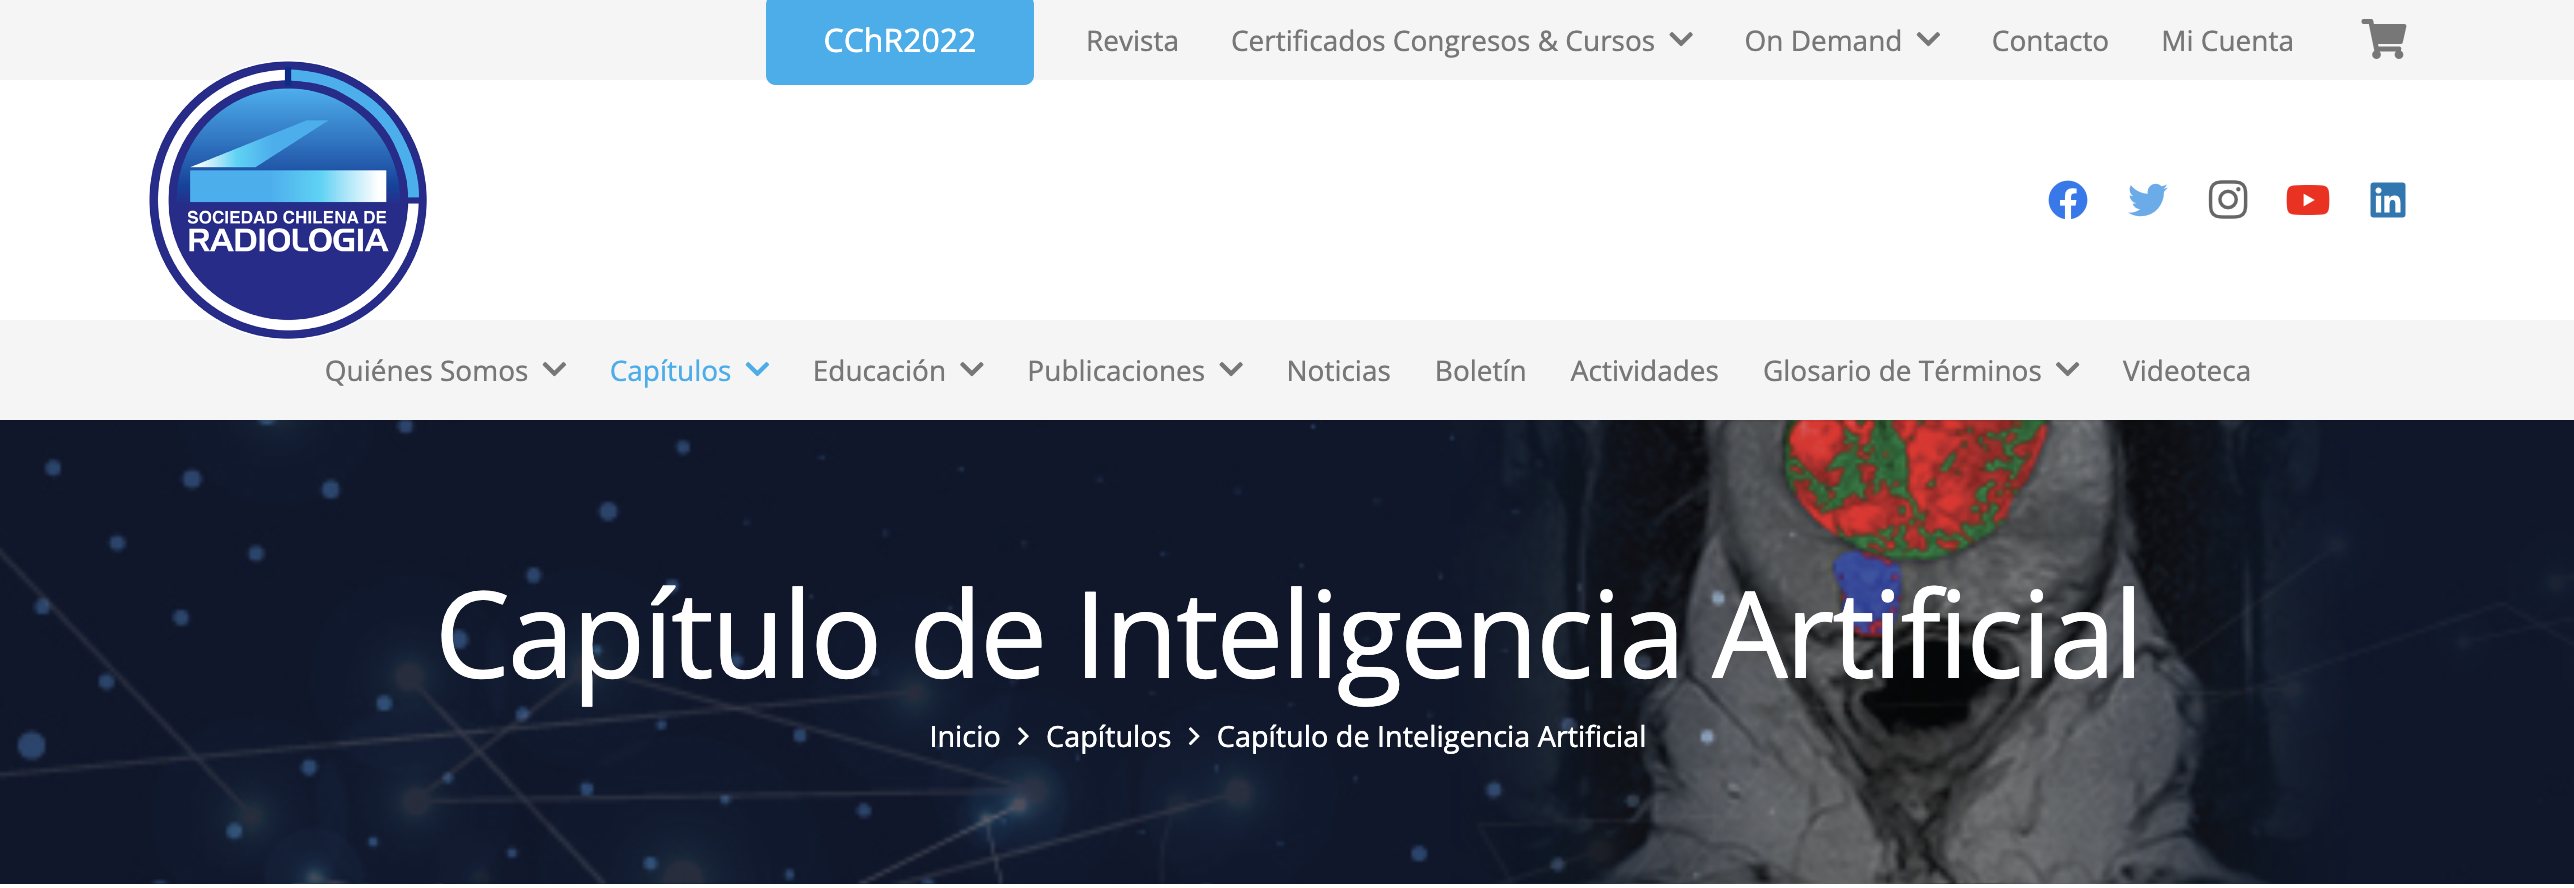